In [79]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from utils import data_visualizer
from utils import data_analyser


# Import Data

In [80]:
df = pd.read_csv("data/Foam Rheometer Data for ML.csv")
data_analysis = data_analyser(df)

# Exploratory Data Analysis

In [81]:
data_analysis.categorical_analysis()

,Categories,Counts,Frequency,Null Count
Gas,"[CO2, N2]","[318, 43]","[0.88, 0.12]",0
Surfactant,"[Armovis EHS + TTM, TTM, Ethoduomeen T/13, Eth...","[75, 70, 54, 54, 45, 36, 27]","[0.21, 0.19, 0.15, 0.15, 0.12, 0.1, 0.07]",0
Concentration,"[1%, 2%]","[343, 18]","[0.95, 0.05]",0
Water Type,"[PW, DI, SW, FW]","[136, 81, 81, 63]","[0.38, 0.22, 0.22, 0.17]",0
Chelating Agent,"[15%, 0%, 0]","[244, 99, 18]","[0.68, 0.27, 0.05]",0
Corrosion Inhibitor,"[0.00%, 1.50%, 0.0%, 0%]","[273, 79, 8, 1]","[0.76, 0.22, 0.02, 0.0]",0


In [82]:
data_analysis.continuous_analysis()

,Mean,Std,Kurtosis,Skewness,Max,Min,Null count
Pressure,1063.71,244.58,10.93,3.59,2000.00,1000.00,0
Temperature,245.15,42.70,-1.75,0.51,300.00,212.00,0
Shear Rate,1001.39,623.39,-1.26,0.09,2000.00,100.00,0
Foam Quality,71.99,2.29,0.18,0.70,80.61,67.89,0
Viscosity,17.48,9.33,6.44,1.84,75.70,3.47,0


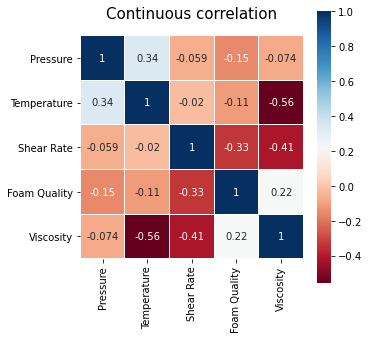

In [83]:
data_analysis.continuous_correlation(figsize=(5,5))

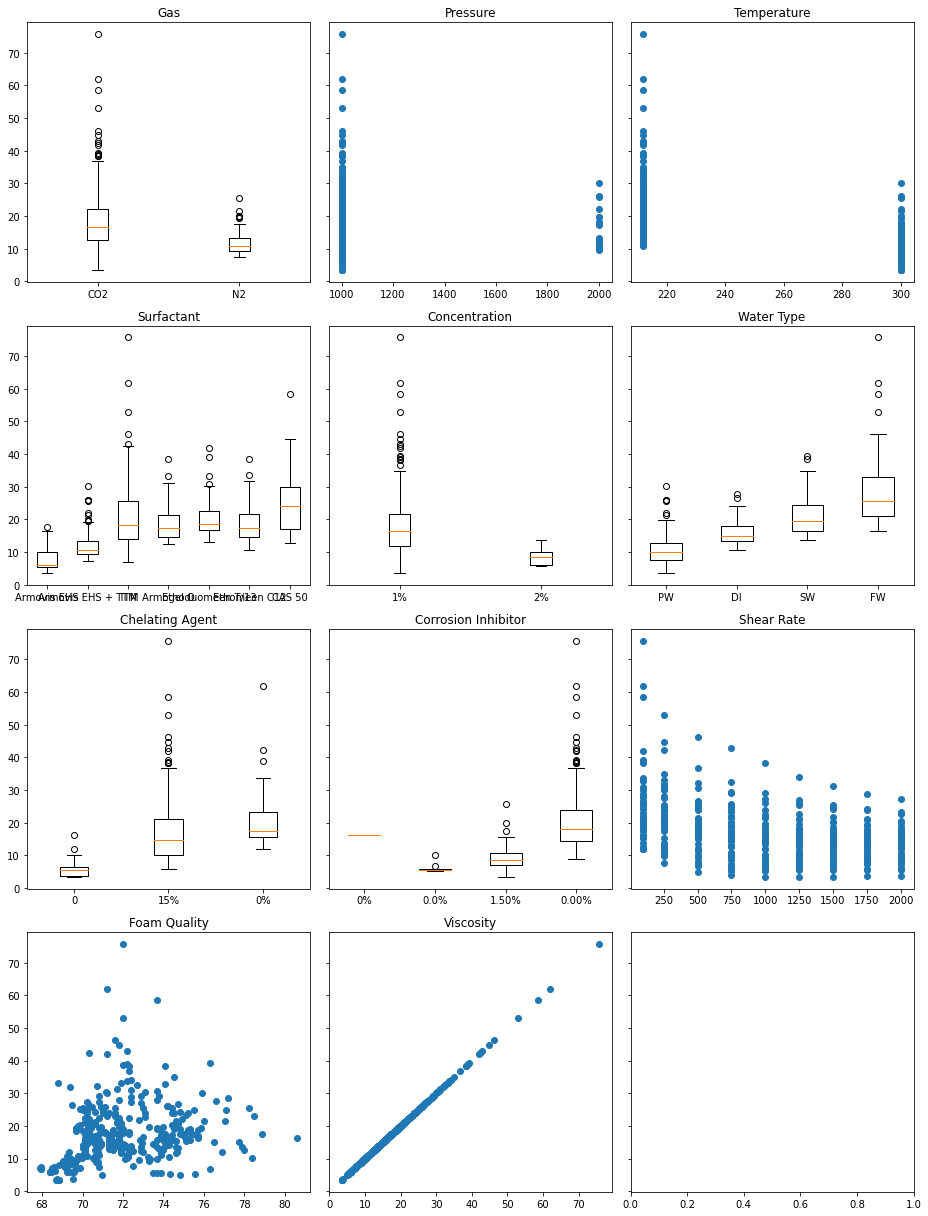

In [84]:
data_visual = data_visualizer(df)
data_visual.all_feature_plots(dependent = "Viscosity", shape = (4,3), figsize = (13,17))

# Preprocessing 

In [85]:
def remove_pc(string):
    if isinstance(string, str):
        string = string.replace('%', '')
        return float(string)

In [86]:
df2 = pd.get_dummies(df, columns=["Gas", "Surfactant", "Water Type"], prefix=["Gas", "Surfactant", "Water"], drop_first = False)

df2['Concentration']=df2['Concentration'].apply(remove_pc)
df2['Corrosion Inhibitor']=df2['Corrosion Inhibitor'].apply(remove_pc)
df2['Chelating Agent']=df2['Chelating Agent'].apply(remove_pc)

df2 = df2.astype("float")

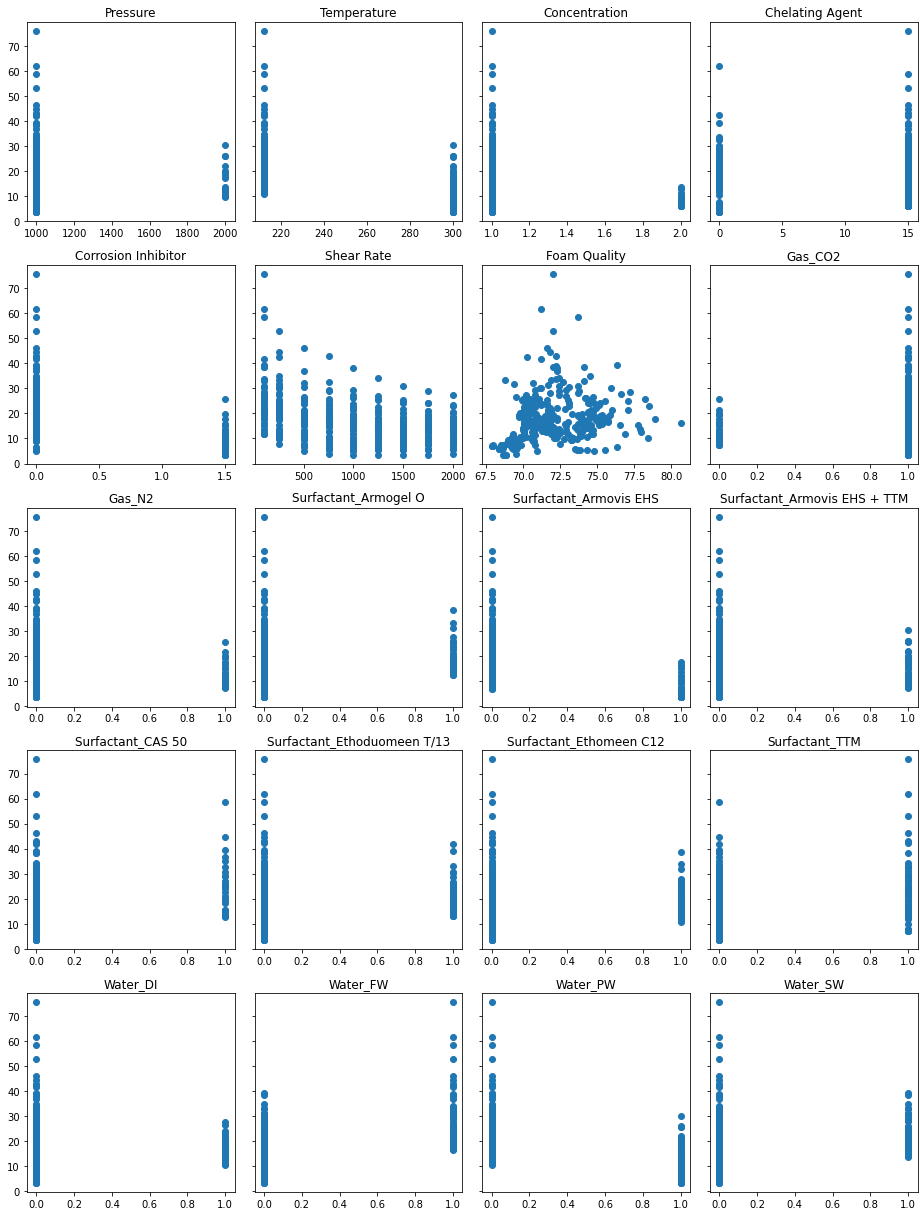

In [87]:
data_visual = data_visualizer(df2)
data_visual.all_feature_plots(dependent = "Viscosity", remove = ["Viscosity"], shape = (5,4), figsize = (13,17))

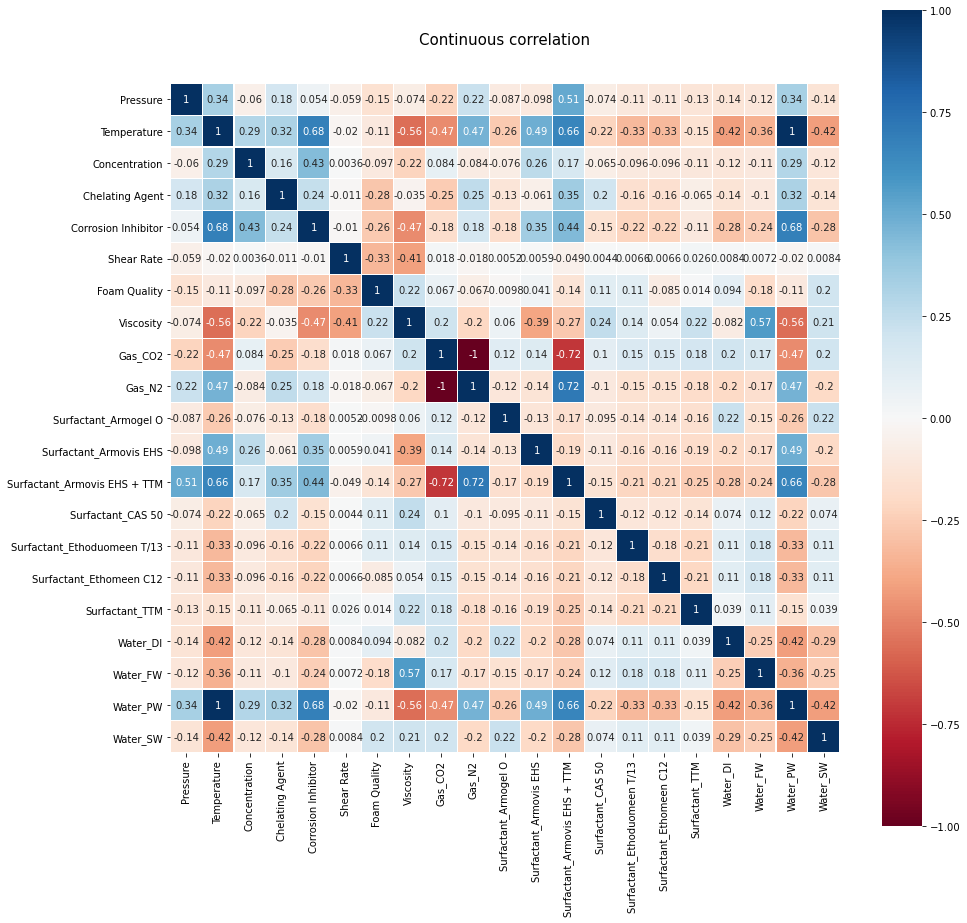

In [88]:
data_analysis = data_analyser(df2)
data_analysis.continuous_correlation(figsize=(15,15))

# Random Forest

In [89]:
y = df2['Viscosity'].values
X = df2.loc[:, df2.columns!='Viscosity'].values

In [90]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, shuffle = True)
pipeline = Pipeline([('clf', RandomForestRegressor(n_estimators = 1000, criterion="mse"))])
param_grid = {'clf__n_estimators':[1000], 
              'clf__max_features': [None, 2,4,6,8,10,12,14],
              'clf__max_depth': [None, 3,5,7]}

grid = GridSearchCV(pipeline, param_grid)
grid.fit(X_train, y_train)


In [ ]:
grid.best_params_

{'clf__max_depth': None, 'clf__max_features': 6, 'clf__n_estimators': 1000}

In [ ]:
def model(X, y, estimator, loops=10, verbose = False):
    """ Trains / Tests a model a specified number of times """

    R2_train = []
    R2_test = []
    
    for _ in range(loops):
        X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.20, shuffle=True)
        pipeline = Pipeline([('clf', estimator)])
        model = pipeline.fit(X_train, y_train)

        predictions_train = model.predict(X_train)
        predictions_test = model.predict(X_test)

        if verbose:
            print(cross_val_score(pipeline, X_train, y_train, scoring='r2', cv=10))
            print(f'R2 Score Train {r2_score(y_train, predictions_train)}')
            print(f'MSE Train {mean_squared_error(y_train, predictions_train)}')
            print(f'R2 Score Test {r2_score(y_test, predictions_test)}')
            print(f'MSE Test {mean_squared_error(y_test, predictions_test)}')

        R2_train.append(r2_score(y_train, predictions_train))
        R2_test.append(r2_score(y_test, predictions_test))
    
    if verbose:
        print(f'R2_train {R2_train}')
        print(f'average {sum(R2_train)/len(R2_train)}')
        print(f'R2_test {R2_test}')
        print(f'average {sum(R2_test)/len(R2_test)}')

    plt.boxplot([R2_train, R2_test], labels=["Train","Test"])
    plt.title('R2_train:' + str(round(sum(R2_train)/len(R2_train),4)) + ', R2_test:' + str(round(sum(R2_test)/len(R2_test),4)))
    plt.grid(True, which='both')
    #plt.hlines(np.arange(0.85, 1, 0.01))

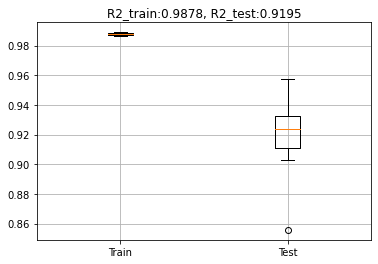

In [ ]:
model(X,y, RandomForestRegressor(n_estimators = 1000, criterion="mse", max_features=6))

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, shuffle = True)
pipeline = Pipeline([('clf', GradientBoostingRegressor(n_estimators = 1000, criterion="mse"))])
param_grid = {'clf__n_estimators':[1000], 
              'clf__max_features': [None, 2,4,6,8,10,12,14],
              'clf__max_depth': [None,3,5,7]}

grid = GridSearchCV(pipeline, param_grid)
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('clf',
                                        GradientBoostingRegressor(criterion='mse',
                                                                  n_estimators=1000))]),
             param_grid={'clf__max_depth': [None, 3, 5, 7],
                         'clf__max_features': [None, 2, 4, 6, 8, 10, 12, 14],
                         'clf__n_estimators': [1000]})

In [ ]:
grid.best_params_

{'clf__max_depth': 3, 'clf__max_features': 4, 'clf__n_estimators': 1000}

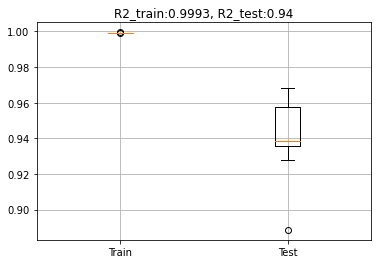

In [ ]:
model(X,y, GradientBoostingRegressor(n_estimators = 1000, criterion="mse", max_depth=3, max_features=4))